## Load data

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import librosa
from IPython.display import Audio
import numpy as np

from itertools import pairwise
import collections

import networkx as nx

In [11]:
import automutualinformation
import pickle

context_dict = {
    0:'Unknown',
    1:'Separation',
    2:'Biting',
    3:'Feeding',
    4:'Fighting',
    5:'Grooming',
    6:'Isolation',
    7:'Kissing',
    8:'Landing',
    9:'Mating protest',
    10:'Threat-like',
    11:'General',
    12:'Sleeping',
}


def load_seq_data( dataset_descriptor, number_of_clusters):
    # Load The Sequences!
    with open(f'/data0/home/h21/luas6629/Thesis/classifiers_{dataset_descriptor}/symbolic_sequences_{dataset_descriptor}_{number_of_clusters}_symseq.pkl','rb') as f:
        symbolic_sequences = pickle.load(f)

    # Load The Graph!
    with open(f'/data0/home/h21/luas6629/Thesis/classifiers_{dataset_descriptor}/graph_symbolic_sequences_{dataset_descriptor}_{number_of_clusters}_graphsymseq.pkl','rb') as f:
        G = pickle.load(f)

    # Load The Sequences!
    with open(f"/data0/home/h21/luas6629/Thesis/classifiers_{dataset_descriptor}/{dataset_descriptor}_{number_of_clusters}_map_complete.pkl",'rb') as f:
        seq_mapped = pickle.load(f)
        seq_mapped.drop_duplicates(subset=["voc_segments_ix"], keep="first", inplace=True)
        seq_mapped.index = range(len(seq_mapped.index))
        seq_mapped.index.set_names('segmentID', inplace=True)
        
    return symbolic_sequences, G, seq_mapped
 

In [12]:
# this will select the df corresponding to number of clusters 
NUM_CLUSTERS = 29

ID_DF = 'bat_215'

#symbolic_sequences_offspring, G_offspring, seq_mapped_offspring = load_seq_data( 'offspring_relationships', 372)
#symbolic_sequences_wildbats, G_wildbats, seq_mapped_wildbats = load_seq_data( 'wildbats_relationships', 175 )
symbolic_sequences_bat_215, G_bat_215, seq_mapped_bat_215 = load_seq_data( ID_DF, NUM_CLUSTERS )

seq_mapped = seq_mapped_bat_215

In [10]:
seq_mapped.head(1)

syllableID_qt_ward  syllableID_et_ward  commonSourceID  \
segmentID                                                           
0                          13                 201               0   

                                                voc_segments  \
segmentID                                                      
0          [1.41432665e-05, -3.5728386e-05, 1.7758794e-05...   

                                             voc_segments_ix  \
segmentID                                                      
0          (61822.0, files201, 121004165931143478.WAV, 0,...   

          voc_segments_duration  emitter  \
segmentID                                  
0                         35952      215   

                                                       mfccs  \
segmentID                                                      
0          [[-740.9281, -738.7967, -738.887, -740.6574, -...   

                                                mel_filtered  \
segmentID                                                      
0          [[2.501173e-08, 6.530185e-08, 7.9928725e-08, 5...   

                                                       specs  ...  \
segmentID                                                     ...   
0          [[1.5232453e-06, 6.4786386e-06, 3.016991e-06, ...  ...   

          temporal_stats label_context label_addressee   FileID    Folder  \
segmentID                                                                   
0               0.000277             6             217  61822.0  files201   

                        File name Pos_segment Start_seg End_seg Emitter  
segmentID                                                                
0          121004165931143478.WAV           0     35795   71747     215  

[1 rows x 28 columns]

# Numerical Stability, Noise reduction and outliers removal

In [355]:
# distribution of time

seq_mapped.specs.apply(lambda x : x.shape[1]).describe()


count    19549.000000
mean        95.385646
std         49.234287
min         21.000000
25%         57.000000
50%         87.000000
75%        125.000000
max        646.000000
Name: specs, dtype: float64

In [510]:
seq_mapped.specs.apply(lambda x : crop_spec(x, 1e-03, 1e-03).shape[1]).describe()

count    19549.000000
mean        92.000256
std         48.470665
min          0.000000
25%         55.000000
50%         84.000000
75%        121.000000
max        638.000000
Name: specs, dtype: float64

<Axes: xlabel='segmentID'>

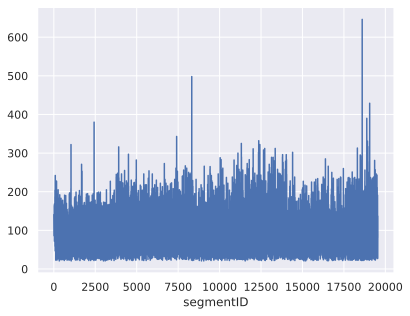

In [356]:
seq_mapped.specs.apply(lambda x : x.shape[1]).plot()

<Axes: xlabel='segmentID'>

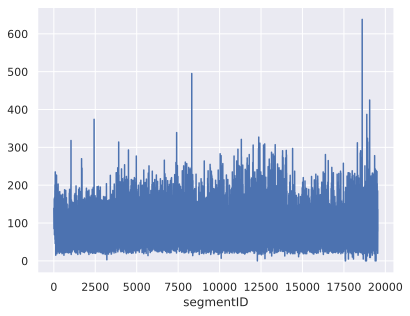

In [511]:
seq_mapped.specs.apply(lambda x : crop_spec(x, 1e-03, 1e-03).shape[1]).plot()

In [364]:
seq_mapped[seq_mapped.specs.apply(lambda x : x.shape[1] > 400 & x.shape[1] < 550)].specs.sample(2).apply(plot_spec, ax=None)

segmentID
9231    None
8583    None
Name: specs, dtype: object

In [108]:
# filter outliers by time

def filter_outliers_by_time(spec_series, return_outliers = False):
    _std = spec_series.apply(lambda x: x.shape[1]).std()
    _mean = spec_series.apply(lambda x: x.shape[1]).mean()
    
    _is_outlier = spec_series.apply(lambda x : (x.shape[1] <= _mean - 3 *_std) |(x.shape[1] >= _mean + 3 *_std))
    
    if return_outliers:
        return spec_series[_is_outlier]
    else:
        return spec_series[_is_outlier ==  False ]
        
    
    
filter_outliers_by_time(seq_mapped.specs, return_outliers = False)

segmentID
0        [[1.5232453e-06, 6.4786386e-06, 3.016991e-06, ...
1        [[6.56751e-06, 3.4977363e-06, 1.5438059e-07, 2...
2        [[1.5433186e-05, 7.1014897e-06, 6.916912e-07, ...
3        [[1.396148e-06, 5.6756846e-07, 2.307436e-07, 2...
4        [[5.03222e-06, 3.059949e-06, 7.7808875e-07, 1....
                               ...                        
19544    [[3.0337326e-06, 1.5130976e-06, 3.102174e-11, ...
19545    [[8.9609193e-07, 4.4648593e-07, 1.6491791e-10,...
19546    [[1.3724749e-05, 7.0441956e-06, 1.2092089e-08,...
19547    [[4.5662443e-07, 3.2813838e-07, 8.463364e-09, ...
19548    [[2.3210373e-06, 1.1582343e-06, 4.6263313e-09,...
Name: specs, Length: 19417, dtype: object

In [504]:
# Crop spectrograms

import math

# crop ?
def crop_spec(spec, rtol =1e-05, atol = 1e-08):
    # left border
    
    extreme_left_ix = 0
    extreme_right_ix = -1
    for i in range(spec.shape[1]):
        if np.allclose(spec[:,i],spec[:,0], rtol = rtol, atol=atol):
            extreme_left_ix = i 
        else:
            break
    
    for j in reversed(range(spec.shape[1])):
        if np.allclose(spec[:,j],spec[:,-1], rtol = rtol, atol=atol):
            extreme_right_ix = j      
        else:
            break
            
    return spec[:,extreme_left_ix : extreme_right_ix]
 
    

In [514]:
sample_spec = seq_mapped.specs.sample().values[0]

S_db = power_spec( sample_spec )

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

print(S_db.shape)
librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax = axes[0])


S_db_cropped = crop_spec(S_db, 1e-03,1e-03)
print(S_db_cropped.shape)
librosa.display.specshow(S_db_cropped, x_axis='time', y_axis='log', ax=axes[1])


(1025, 84)
(1025, 83)


In [551]:
plot_spec(sample_spec, ax=None)

In [115]:
import matplotlib.pyplot as plt


def plot_spec(spec , ax):
    
    #S_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
    S_db = librosa.power_to_db(spec ** 2, ref=np.max)
    librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax = ax)
    

images = filter_outliers_by_time(seq_mapped.specs, return_outliers = True).sample(100).values

grid_size = 10

# Create a figure and a grid of subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Iterate over the subplots and plot the images
for i in range(grid_size):
    for j in range(grid_size):
        ax = axes[i, j]
        plot_spec( images[i*grid_size + j] , ax)  # Replace `images` with your list of images
        ax.axis('off')  # Turn off axis labels

# Adjust spacing between subplots
plt.tight_layout()

fig.suptitle(f'''
    Testing presence of outliers 
    (Z-score on Time Dimension, Data: {ID_DF})
    ''')

plt.subplots_adjust(top=0.9)


plt.savefig(f'/data0/home/h21/luas6629/Thesis/classifiers_{ID_DF}/{NUM_CLUSTERS}_clusters_outliers_testing_time_dimension.png',
            dpi =300,
            bbox_inches='tight')


# Show the plot
plt.show()





In [121]:
_is_outliers = filter_outliers_by_time(seq_mapped.specs, return_outliers = False) \
    .apply(lambda spec : librosa.power_to_db(spec ** 2, ref=np.max))

In [543]:
sample_spec.shape, librosa.util.pad_center(sample_spec, size=646, axis=1).shape

((1025, 84), (1025, 646))

In [555]:
def pad_center(spec, times, mode='minimum' ):
    return librosa.util.pad_center(spec, mode=mode, size = times, axis=-1)

max_time = max(x.shape[1] for x in _is_outliers)

plot_spec(pad_center(_is_outliers.loc[19547], max_time), ax=None)

In [283]:
def power_spec(spec):
    return librosa.power_to_db(spec ** 2, ref=np.max)

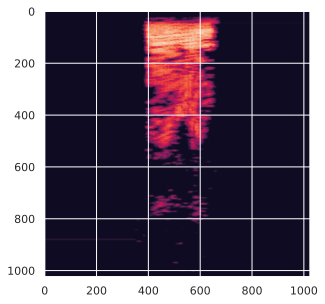

In [293]:
from PIL import Image

size=1024
spec =  pad_center(power_spec(seq_mapped.loc[19547].specs), max_time)

resized_spec = np.array(Image.fromarray(spec).resize((size, size), resample=Image.LANCZOS))
        

plt.imshow(resized_spec)

In [562]:
tensor_sample = torch.from_numpy( power_spec(sample_spec) )

In [639]:
tensor_sample_norm = (tensor_sample / tensor_sample.amax(dim=(0,1)))

In [637]:
tensor_sample_norm = torch.nn.functional.normalize(tensor_sample, p=2.0, dim=(0,1), eps=1e-12, out=None)



In [633]:
tensor_sample_norm.min()

tensor(-0.0384)

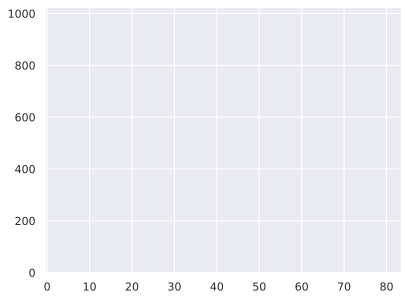

In [640]:
plt.imshow(tensor_sample_norm, origin='lower', aspect='auto')

# AE using test on one bat

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [329]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../test_data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial9"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/tmp/ipykernel_3392931/4185403413.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: cuda:0


In [330]:
ls {DATASET_PATH}

cifar-10-batches-py/  cifar-10-python.tar.gz


In [331]:
from PIL import Image
from sklearn.model_selection import train_test_split


class SpectrogramDataset():
    def __init__(self, Dataset, transform=None, max_padding_time = 646):
        self.Dataset = Dataset
        self.transform = transform
        self.max_padding_time = max_padding_time

    def __len__(self):
        return len(self.Dataset)

    def __getitem__(self, idx):
        spectrogram = np.array(self.Dataset.iloc[idx]['specs'])
        
        # transform specs
        spectrogram = self.power_spec(spectrogram)
        
        # If i min max, I should use MSE loss function with sum, or with mean mode it won't train (it will be 0) this also because of padding
        # spectrogram = self.min_max_scale(spectrogram)
        spectrogram = self.pad_center(spectrogram, self.max_padding_time)
        spectrogram = self.resize_spec(spectrogram)
        #spectrogram = torch.from_numpy(spectrogram)
        #spectrogram = torch.nn.functional.normalize(spectrogram, p=2.0, dim=(0,1))
        #spectrogram = spectrogram.numpy()
        
        label = self.Dataset.iloc[idx]['label_context']
        if self.transform:
            spectrogram = self.transform(spectrogram)
        
        return spectrogram, label
    
    def power_spec(self, spec):
        return librosa.power_to_db(spec ** 2, ref=np.max)
    
    def pad_center(self, spec, max_padding_time, mode='minimum'):
        # padding with minimum: input is power_spec (minimum is typically -80 db retlative to max 0)
        return librosa.util.pad_center(spec, mode=mode, size = max_padding_time, axis=-1)
           
    def resize_spec(self, spec):

        # try to convert to int => denoise, power ** 2, back to float
        #spec = ((spec * 100000).astype(int) ** 1.0)

        size  =  32


        #spec = np.array(Image.fromarray(spec).resize((int(np.shape(spec)[1]),  32), resample=Image.LANCZOS))
        spec = np.array(Image.fromarray(spec).resize((size, size), resample=Image.LANCZOS))
        
        
        # this is max mean+std 
        #pad_length = int((256 - spec.shape[1])/2)
        #spec = np.pad(spec, ((0,0),(pad_length, pad_length)), mode = 'constant')

        return (spec).astype('float32')
    
    def min_max_scale(self, spectrogram):
        return (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())

# define the transformation to convert spectrograms into images
transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((32, 32)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,),(0.5,))
])


X_train, X_test, y_train, y_test = train_test_split(
    seq_mapped, 
    seq_mapped, 
    test_size=0.20, 
    random_state=42)



# create the dataset
train_dataset = SpectrogramDataset(X_train, transform=transform, max_padding_time = 646)
train_dataset[0][0].shape

test_set = SpectrogramDataset(X_test, transform=transform, max_padding_time = 646)

In [372]:
train_dataset.Dataset.specs.iloc[0]

TypeError: SpectrogramDataset.__init__() missing 1 required positional argument: 'Dataset'

In [333]:
size_train = int(len(train_dataset)*0.9)
size_val = len(train_dataset) - size_train

train_set, val_set = torch.utils.data.random_split(train_dataset, [size_train, size_val])

In [334]:
# create the data loader
train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=32)
val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=32)
test_loader = data.DataLoader(test_set, batch_size=32, shuffle=False, drop_last=False, num_workers=32)


def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

In [337]:
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
                 #act_fn : object = nn.GELU):
        
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        
        
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )
        """
 
        self.net = nn.Sequential(

            
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )        

       """ 
    def forward(self, x):
        return self.net(x)

In [338]:
Encoder(num_input_channels = 1, base_channel_size = 32, latent_dim = 64).forward(get_train_images(1))

tensor([[-2.2402e-02,  4.6691e-02, -1.4032e-01,  3.1327e-02, -1.0279e-02,
          7.7358e-02, -7.3810e-03, -1.1114e-01,  2.3126e-02,  8.8355e-02,
          6.7522e-02, -1.6614e-01, -1.6139e-01, -6.0457e-02,  5.9102e-02,
         -2.1235e-01, -5.1308e-02,  8.7756e-02, -6.1703e-02, -5.2294e-02,
          1.2183e-01, -3.8934e-02,  1.0510e-01, -2.0302e-02,  8.7507e-02,
         -1.4001e-01, -1.0813e-01, -2.1818e-02,  1.5407e-01, -1.1551e-01,
          2.1280e-01, -1.6893e-02,  1.6787e-01,  2.6284e-01, -1.2029e-01,
         -8.9145e-02,  1.5687e-01, -1.8939e-02, -1.5409e-01,  7.5094e-02,
         -1.9862e-01,  5.8049e-02, -1.3730e-01,  5.3121e-02,  1.7536e-01,
          1.5166e-04,  2.3971e-01, -3.2649e-02, -8.8376e-02,  7.8246e-02,
         -1.6022e-01,  2.0499e-01, -6.8485e-02, -8.1502e-02,  1.3779e-01,
         -4.3580e-02, -7.1278e-02, -7.3543e-02, -1.4987e-01,  3.2887e-01,
          1.0576e-01, -1.9196e-01, -5.2374e-03,  1.7266e-01]],
       grad_fn=<AddmmBackward0>)

In [323]:
def is_correct_layer_reduction(input_size, kernel_size, padding, stride, dilatation = 1):
    #output_size = (input_size - kernel_size +  padding) / stride + 1
    output_size = (input_size + 2*padding - dilatation * (kernel_size -1) - 1 )/ stride + 1
    return output_size

is_correct_layer_reduction(64, 32, 3, 2)

20.0

In [218]:
get_train_images(2).shape

torch.Size([2, 1, 64, 64])

In [278]:
nn.Linear(2*16*32, 64)

Linear(in_features=1024, out_features=64, bias=True)

In [ ]:
Encoder(1,1,32).forward(Encoder(1,1,64).forward(get_train_images(1)))

In [315]:
inp = torch.randn(10, 1, 512, 512)
c_hid = 32
act_fn = nn.GELU
arch = nn.Sequential(
    nn.Conv2d(1, c_hid, kernel_size=5, padding=1, stride=2), #  512 x 512 => 256x256,
    act_fn(),
    nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=1), #  256 x 256 => 128x128,
    act_fn(),
    nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=1),
    act_fn(),
    nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=2), # 256x256 => 128x128,
    act_fn(),
    nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=1),
    act_fn(),
    nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=2), # 128x128 => 64x64
    act_fn(),
    nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=2), # 64x64 => 32x32
    act_fn(),
    nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
    act_fn(),
    nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
    act_fn(),
    nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
    act_fn(),
    nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
    act_fn(),
    nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
    act_fn(),
    nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
    act_fn(),

#nn.Flatten(), # Image grid to single feature vector
    
)
outp = arch(inp)
print('outp.shape:', outp.shape)

outp.shape: torch.Size([10, 64, 4, 4])


In [ ]:
def is_correct_layer_reduction(input_size, kernel_size, padding, stride):
    output_size = (input_size - kernel_size + 2 * padding) / stride + 1
    return output_size

is_correct_layer_reduction(64, 1, 1, 2), is_correct_layer_reduction(32, 3, 1, 2)

In [324]:
class Decoder(nn.Module):


    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
                 #act_fn : object = GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32    
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
        
        """
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            nn.Unflatten(1, (2*c_hid, 4, 4)),
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, stride=2, padding=1, output_padding=1), # 4x4 => 8x8
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, stride=2, padding=1, output_padding=1), # 8x8 => 16x16
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, stride=2, padding=1, output_padding=1), # 16x16 => 32x32
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, stride=2, padding=1, output_padding=1), # 32x32 => 64x64
            act_fn(),
            nn.ConvTranspose2d(c_hid, c_hid, kernel_size=3, stride=2, padding=1, output_padding=1), # 64x64 => 128x128
            act_fn(),
            nn.ConvTranspose2d(c_hid, c_hid, kernel_size=3, stride=2, padding=1, output_padding=1), # 128x128 => 256x256
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, stride=2, padding=1, output_padding=1), # 256x256 => 512x512
            act_fn(),
            nn.ConvTranspose2d(num_input_channels, num_input_channels, kernel_size=3, stride=2, padding=1, output_padding=1), # 512x512 => 1024x1024
            nn.Tanh()
        )
        
        """
        
        
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [364]:
class Autoencoder(pl.LightningModule):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 1,
                 width: int = 32,
                 height: int = 32):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
        # losses
        self.losses = {latent_dim : []}

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)
        
        
        #loss = F.mse_loss(x, x_hat, reduction="none")
        
        
        loss = F.mse_loss(x, x_hat, reduction="sum") # I choose to use mean with log-scaled spec [-80, 0]
        #loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        loss.sum().mean(dim=[0])
        #print(loss)
        
        self.losses[latent_dim].append( loss )
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

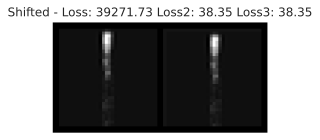

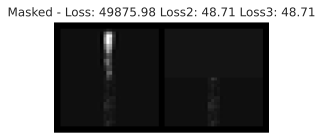

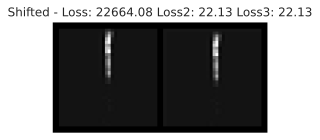

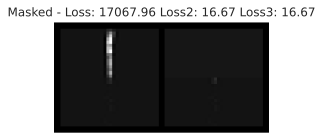

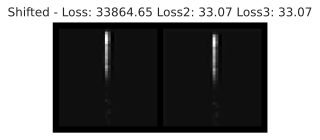

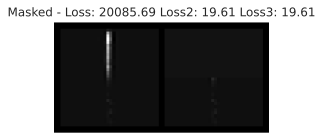

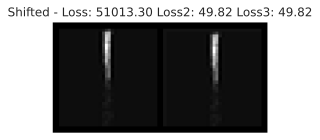

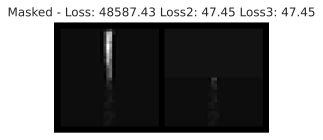

In [327]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss = F.mse_loss(img1, img2, reduction="sum")
    
    
    # Plot images for visual comparison
    #img1 = librosa.power_to_db(img1, ref=np.max)
    #img2 = librosa.power_to_db(img2, ref=np.max)
        
    
    #img1 = torch.tensor(img1)
    #img2 = torch.tensor(img2)
    
    loss2 = F.mse_loss(img1, img2, reduction="mean")
    loss3 = F.mse_loss(img1, img2, reduction="none")
    

    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f} Loss2: {loss2.item():4.2f} Loss3: {loss2.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(2000, 2004):
    # Load example image
    img, _ = train_dataset[i]

    img_mean = img.mean(dim=[1,2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

In [66]:
class GenerateCallback(pl.Callback):

    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
                
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

In [361]:
CHECKPOINT_PATH

'../saved_models/tutorial9'

In [362]:
def train_AE_bat(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"ae_1024_bat_{latent_dim}"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=10,
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8), every_n_epochs=2),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"ae_1024_bat_{latent_dim}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = Autoencoder.load_from_checkpoint(pretrained_filename)
    else:
        model = Autoencoder(base_channel_size=32, latent_dim=latent_dim, width = 32, height =  32)
        trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    return model, result

In [ ]:
model_dict = {}
for latent_dim in [64, 128, 256, 384]:
    model_ld, result_ld = train_AE_bat(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

In [351]:
model_dict[64]

{'model': Autoencoder(
   (encoder): Encoder(
     (net): Sequential(
       (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (1): GELU(approximate='none')
       (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (3): GELU(approximate='none')
       (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (5): GELU(approximate='none')
       (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (7): GELU(approximate='none')
       (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (9): GELU(approximate='none')
       (10): Flatten(start_dim=1, end_dim=-1)
       (11): Linear(in_features=1024, out_features=64, bias=True)
     )
   )
   (decoder): Decoder(
     (linear): Sequential(
       (0): Linear(in_features=64, out_features=1024, bias=True)
       (1): GELU(approximate='none')
     )
     (net): Sequential(
       (0): ConvTranspose2d(64, 64, kernel_size=(

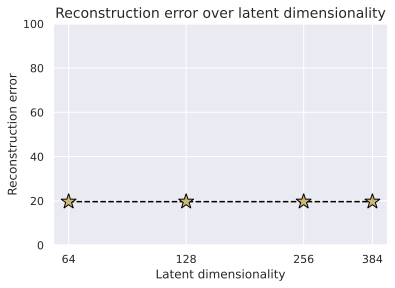

In [369]:
latent_dims = sorted([k for k in model_dict])
val_scores = np.array([model_dict[k]["result"]["val"][0]["test_loss"] for k in latent_dims]) / 1.0e+07

fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0,100)
plt.show()

In [366]:
val_scores

[6012.30859375]

In [24]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

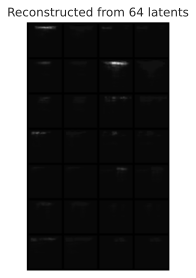

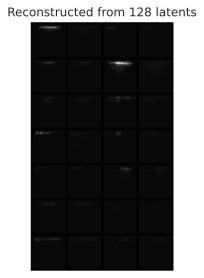

In [29]:
input_imgs = get_train_images(14)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)

In [28]:
len(input_imgs)

4

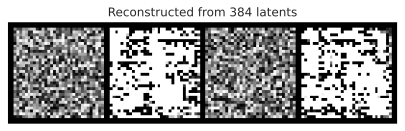

In [33]:
rand_imgs = torch.rand(2, 1, 32, 32) * 2 - 1
visualize_reconstructions(model_dict[384]["model"], rand_imgs)

In [36]:
plain_imgs = torch.zeros(4, 1, 32, 32)

# Single color channel
plain_imgs[1,0] = 1
# Checkboard pattern
plain_imgs[2,:,:16,:16] = 1
plain_imgs[2,:,16:,16:] = -1
# Color progression
#xx, yy = torch.meshgrid(torch.linspace(-1,1,32), torch.linspace(-1,1,32))
#plain_imgs[3,0,:,:] = xx
#plain_imgs[3,1,:,:] = yy

visualize_reconstructions(model_dict[256]["model"], plain_imgs)

In [40]:
model = model_dict[256]["model"]
latent_vectors = torch.randn(8, model.hparams.latent_dim, device=model.device)
with torch.no_grad():
    imgs = model.decoder(latent_vectors)
    imgs = imgs.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

In [41]:
# We use the following model throughout this section.
# If you want to try a different latent dimensionality, change it here!
model = model_dict[128]["model"]

In [42]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        img_list.append(imgs)
        embed_list.append(z)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

train_img_embeds = embed_imgs(model, train_loader)
test_img_embeds = embed_imgs(model, test_loader)

Encoding images:   0%|          | 0/369 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/202 [00:00<?, ?it/s]

In [43]:
def find_similar_images(query_img, query_z, key_embeds, K=8):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    dist = torch.cdist(query_z[None,:], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    # Plot K closest images
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

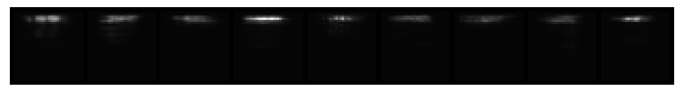

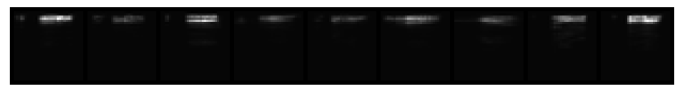

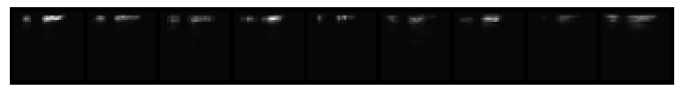

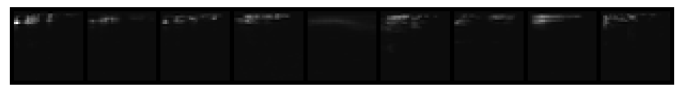

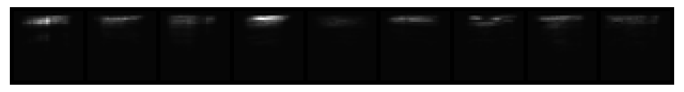

In [81]:
# Plot the closest images for the first N test images as example
for i in range(8):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)


In [45]:
# We use the following model throughout this section.
# If you want to try a different latent dimensionality, change it here!
model = model_dict[128]["model"]

In [46]:
# Create a summary writer
writer = SummaryWriter("tensorboard/")

In [47]:
# Note: the embedding projector in tensorboard is computationally heavy.
# Reduce the image amount below if your computer struggles with visualizing all 10k points
NUM_IMGS = len(test_set)

writer.add_embedding(test_img_embeds[1][:NUM_IMGS], # Encodings per image
                     metadata=[test_set[i][1] for i in range(NUM_IMGS)], # Adding the labels per image to the plot
                     label_img=(test_img_embeds[0][:NUM_IMGS]+1)/2.0) # Adding the original images to the plot

In [51]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [ ]:
tensorboard --logdir=logs --port 5000

In [132]:
pwd

'/data0/home/h21/luas6629/Thesis'

In [134]:
%tensorboard --logdir tensorboard/

Reusing TensorBoard on port 6006 (pid 1411078), started 1:17:11 ago. (Use '!kill 1411078' to kill it.)

# Refine 

In [222]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

model2 = create_feature_extractor(model_test, { 'encoder.net.11': 'latent_space'})


In [223]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)


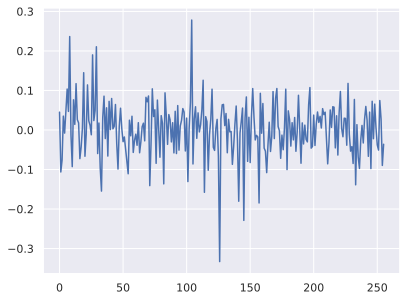

In [224]:
plt.plot(model2(sample)['latent_space'][10].cpu().data)

In [238]:
import umap


umap_model = umap.UMAP(
        n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean',
)

segs = [x.cpu().data.numpy() for x in model2(sample)['latent_space']]

embedding = umap_model.fit_transform(segs)


import hdbscan

# cluster with HDBSCAN
z = np.vstack(embedding)
clusterer = hdbscan.HDBSCAN(
        # min_cluster_size should be the smallest size we would expect a cluster to be
        min_cluster_size=int(len(z) * 0.01), 
        min_samples = 20,
        cluster_selection_epsilon = 0.01,
        cluster_selection_method = 'leaf',
        #allow_single_cluster=True, 
        prediction_data=True # soft clustering

    ).fit(z)
#seq_mapped_test.loc[:,'hdbscan_labels'] = list(clusterer.labels_)
#seq_mapped_test.hdbscan_labels.unique().shape
#
#seq_mapped.loc[:,'hdbscan_labels'] = list(clusterer.labels_)
#seq_mapped.hdbscan_labels.unique().shape




In [349]:
ix_not_noise = np.argwhere(clusterer.labels_ > -1).flatten()
ix_noise = np.argwhere(clusterer.labels_ == -1).flatten()

y_train_hdbscan_sub = np.take(clusterer.labels_, ix_not_noise)
X_train_hdbscan_sub = np.vstack(np.take(embedding, ix_not_noise, axis=0))

y_pred_hdbscan_sub = np.take(clusterer.labels_, ix_noise)
X_pred_hdbscan_sub = np.vstack(np.take(embedding, ix_noise, axis=0))


In [296]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)

In [295]:
nca = NeighborhoodComponentsAnalysis()
nca.fit(X_train_hdbscan_sub, y_train_hdbscan_sub)

NeighborhoodComponentsAnalysis()

In [359]:
nca.fit(X_train_hdbscan_sub, y_train_hdbscan_sub)

NeighborhoodComponentsAnalysis()

In [360]:
knn = KNeighborsClassifier(
    n_neighbors=5,
    weights = 'distance',
    n_jobs = -1)
knn.fit(X_train_hdbscan_sub, y_train_hdbscan_sub)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [318]:
NCA_embedding = nca.transform(embedding)

In [329]:
ext_labels = np.array(list(clusterer.labels_).copy())

In [352]:
ext_labels[ix_noise] = knn.predict(X_pred_hdbscan_sub)

In [357]:
# Plot the projected points and show the evaluation score
plt.scatter(NCA_embedding[:, 0], NCA_embedding[:, 1], c=ext_labels, s=30, cmap="Set1")

In [211]:
y_hat.shape

torch.Size([1000, 1, 32, 32])

In [372]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("nca", NeighborhoodComponentsAnalysis()),
            ("knn", KNeighborsClassifier(
                n_neighbors=1,
                weights = 'uniform',
                n_jobs = -1
            )),
        ]
    )

pipe.fit(X_train_hdbscan_sub, y_train_hdbscan_sub)

ext_labels = np.array(list(clusterer.labels_).copy())
ext_labels[ix_noise] = pipe.predict(X_pred_hdbscan_sub)



<Axes: >

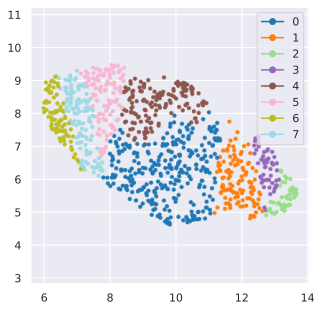

In [373]:
fig, ax = plt.subplots(figsize=(5, 5))
#scatter_projections(projection=z, alpha=0.05, labels=None, s=5, ax=ax)
scatter_projections(
    projection=embedding,
    alpha=1.,
    #labels=seq_mapped.label_context,
    labels =ext_labels,
    s=10,
    ax=ax,
)
#ax.legend('off')
#ax.set_xlim([-5,15])
#ax.set_ylim([-15,15])

/data0/home/h21/luas6629/avgn_paper/avgn/visualization/projections.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  colors = np.array([lab_dict[i] for i in labels])


TypeError: Invalid shape (256,) for image data

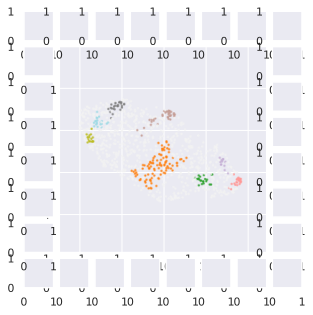

In [371]:
from avgn.visualization.projections import scatter_spec

scatter_spec(
    z,
    segs,
    
    #[ sigmoid(s) for s in segs_reshaped[:1000]],
    
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(5, 5),
    range_pad = 0.15,
    scatter_kwargs = {
        #'labels': seq_mapped[:1000].label_context.apply(lambda x : context_dict[x]),
        #'labels': seq_mapped.hdbscan_labels,
        'labels' : list(clusterer.labels_),
        'alpha':.75,
        's': 2,
        'show_legend': False,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.colormaps['gray']
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.2,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 1,

);
#ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats')
#save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'UMAP_feats', dpi=300, save_jpg=True)

(<matplotlib.collections.QuadMesh at 0x7f4242904d00>,
 (32, 32),
 torch.Size([1000, 1, 32, 32]),
 (32, 32))

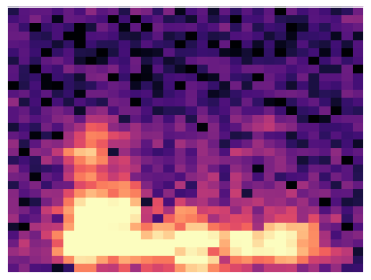

In [234]:
D = y_hat[23].reshape(32,32).cpu().data.numpy()
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(S_db), S_db.shape, sample.shape, D.shape

(<matplotlib.collections.QuadMesh at 0x7f4242950d00>,
 (32, 32),
 torch.Size([1000, 1, 32, 32]),
 (32, 32))

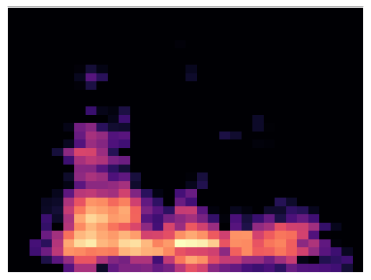

In [235]:
D = sample[23].reshape(32,32).cpu().data.numpy()
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(S_db), S_db.shape, sample.shape, D.shape

In [217]:
y_hat[0].reshape(32,32)

torch.Size([32, 32])

# Simpler ?

In [13]:
TRAIN_SIZE=5000
BATCH_SIZE=128
TEST_SIZE=1000
#DIMS = (32, 24, 1)
DIMS = (128, 96, 1,)
N_TRAIN_BATCHES =int((TRAIN_SIZE-TEST_SIZE)/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_SIZE/BATCH_SIZE)
TRAIN_BUF = 1000
TEST_BUF = 1000

In [5]:
seq_mapped.shape

(19549, 28)

In [14]:
from PIL import Image
def power_spec(spec):
    return librosa.power_to_db(spec ** 2, ref=np.max)

def pad_center(spec, max_padding_time, mode='minimum'):
    # padding with minimum: input is power_spec (minimum is typically -80 db retlative to max 0)
    return librosa.util.pad_center(spec, mode=mode, size = max_padding_time, axis=-1)
           
def resize_spec(spec, size = 128):

    spec = np.array(Image.fromarray(spec).resize((size, 96), resample=Image.LANCZOS))
    
    return (spec).astype('float32')

def preprocess_spec(spec):
    return resize_spec(power_spec(spec), size =128)
    #return resize_spec(contrast_spec(spec), size = 32)

In [15]:
import tensorflow as tf
msg = tf.constant('Hello, TensorFlow!')
tf.print(msg)

Hello, TensorFlow!


In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [17]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

2023-05-29 10:33:12.715909: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


False

In [18]:
print(tf.test.is_gpu_available())

False


2023-05-29 10:33:13.506670: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [19]:
import sys
print (sys.version)
# 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
import tensorflow as tf
print(tf.__version__)
# my output was => 1.13.1

3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]
2.12.0


In [18]:
data = seq_mapped[['specs', 'label_context']].copy()
data = data.sample(frac = 1)

In [1069]:
data

specs label_context
segmentID                                                                 
12278      [[2.0917985e-06, 1.0448712e-06, 3.836252e-09, ...            12
9308       [[3.4772713e-06, 1.7439304e-06, 6.7303364e-11,...            12
18621      [[1.9876077e-06, 9.884147e-07, 6.7994555e-12, ...             9
361        [[1.694144e-05, 6.850624e-05, 0.0001372374, 0....            12
8834       [[0.00050125463, 0.00024378666, 2.576988e-06, ...             9
...                                                      ...           ...
13374      [[2.3340688e-05, 1.1668936e-05, 3.3904705e-08,...             9
9624       [[2.7668787e-06, 1.3846205e-06, 1.1889756e-09,...            12
10277      [[3.966449e-06, 9.738353e-07, 8.546563e-08, 6....            12
17321      [[6.635157e-06, 3.3091947e-06, 4.119663e-08, 2...            11
16997      [[9.7521486e-05, 0.00012768495, 8.273127e-05, ...             9

[19549 rows x 2 columns]

In [21]:
sample = data.sample()
sample_spec = sample.specs.values[0]
sample_label = sample.label_context

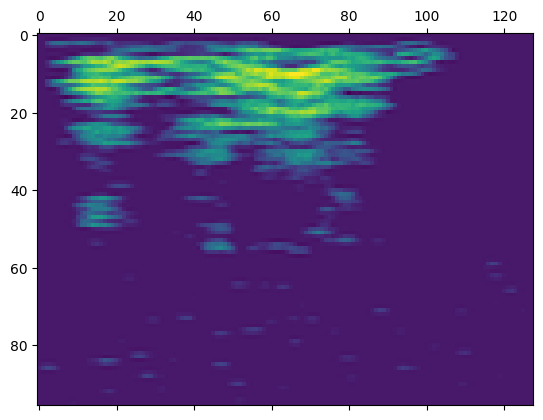

In [22]:
plt.matshow(preprocess_spec(sample_spec).squeeze())
plt.grid(False)

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

# the nightly build of tensorflow_probability is required as of the time of writing this 
#import tensorflow_probability as tfp
#ds = tfp.distributions

In [25]:
N_Z = 32
encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="gelu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="gelu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="gelu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z),
]

decoder = [
    tf.keras.layers.Dense(units=4 * 3 * 1760, activation="gelu", input_shape=(N_Z,)),
    tf.keras.layers.Reshape(target_shape=(4, 3, 1760)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="gelu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="gelu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="gelu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="tanh"
    ),
    
    tf.keras.layers.experimental.preprocessing.Resizing(128, 96)
]

In [26]:
for layer in tf.keras.Sequential(encoder).layers:
    print("Input shape:", layer.input_shape)
    print("Output shape:", layer.output_shape)
    print()

Input shape: (None, 128, 96, 1)
Output shape: (None, 63, 47, 32)

Input shape: (None, 63, 47, 32)
Output shape: (None, 31, 23, 64)

Input shape: (None, 31, 23, 64)
Output shape: (None, 15, 11, 128)

Input shape: (None, 15, 11, 128)
Output shape: (None, 21120)

Input shape: (None, 21120)
Output shape: (None, 32)



In [24]:
for layer in tf.keras.Sequential(decoder).layers:
    print("Input shape:", layer.input_shape)
    print("Output shape:", layer.output_shape)
    print()

Input shape: (None, 32)
Output shape: (None, 21120)

Input shape: (None, 21120)
Output shape: (None, 4, 3, 1760)

Input shape: (None, 4, 3, 1760)
Output shape: (None, 8, 6, 128)

Input shape: (None, 8, 6, 128)
Output shape: (None, 16, 12, 64)

Input shape: (None, 16, 12, 64)
Output shape: (None, 32, 24, 32)

Input shape: (None, 32, 24, 32)
Output shape: (None, 32, 24, 1)

Input shape: (None, 32, 24, 1)
Output shape: (None, 128, 96, 1)



In [38]:
from avgn.tensorflow.AE import AE, plot_reconstruction

PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis


In [ ]:
del

In [40]:
train_data = data.specs.iloc[:TRAIN_SIZE].apply(preprocess_spec).apply(lambda x: np.asarray(x.T).astype('float32'))
test_data = data.specs.iloc[-TEST_SIZE:].apply(preprocess_spec).apply(lambda x: np.asarray(x.T).astype('float32'))

# if using power_spec
train_data = train_data.apply(lambda x : (x + 80) * (255 / 80))
test_data = test_data.apply(lambda x : (x + 80) * (255 / 80))


#train_data = train_dataset.apply(lambda x :  (x - x.min()) / (x.max() - x.min()))
#test_data = test_dataset.apply(lambda x :  (x - x.min()) / (x.max() - x.min()))

In [41]:
plt.matshow(test_data.iloc[0])

In [42]:
test_dataset = tf.convert_to_tensor(np.array(test_data.tolist()))
train_dataset = tf.convert_to_tensor(np.array(train_data.tolist()))

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset).batch(BATCH_SIZE)



In [15]:
# the optimizer for the model
optimizer = tf.keras.optimizers.Adam(1e-3)
# train the model
model = AE(
    enc = encoder,
    dec = decoder,
    optimizer = optimizer,
)

TypeError: AE.__init__() got an unexpected keyword argument 'optimizer'

In [713]:
next(iter(test_dataset)).shape

TensorShape([64, 32, 24])

In [869]:
#example_data = next(iter(test_dataset))

#example_data = np.array(test_dataset[:BATCH_SIZE].tolist())
example_data = next(iter(test_dataset))
example_data = (
        tf.cast(tf.reshape(example_data, [BATCH_SIZE] + list(DIMS)), tf.float32)
        / 255
        
)

In [848]:
model.enc(example_data);

In [780]:
76800/ 49152

1.5625

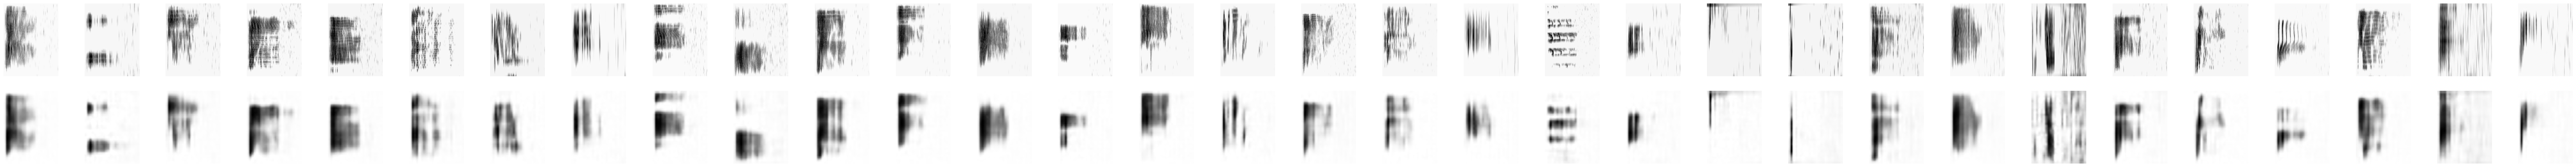

In [905]:
plot_reconstruction(model, example_data, N_Z)

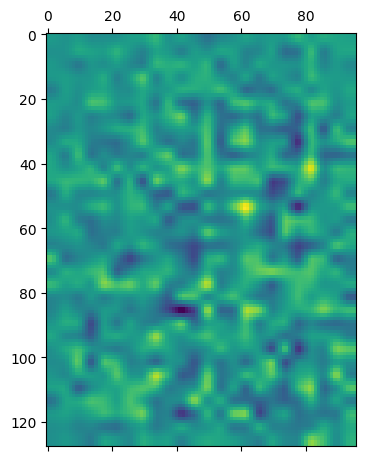

In [871]:
plt.matshow( model.decode(model.encode(example_data))[0] )

In [527]:
model.decode(model.encode(example_data))[24][0];

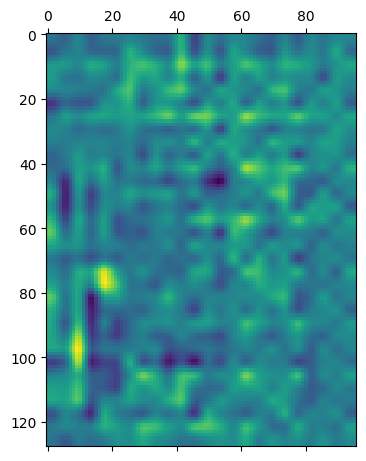

In [904]:
sample_tensor = tf.convert_to_tensor(preprocess_spec(sample_spec).T)

sample_tensor = (
        tf.cast(tf.reshape(sample_tensor, [1] + list(DIMS)), tf.float32)
        / 255
)

plt.matshow(tf.reshape( model.decode(model.encode(sample_tensor))[0], [128, 96]) )

In [876]:
tf.reshape( model.decode(model.encode(sample_tensor))[0], [128,96]).shape, preprocess_spec(sample_spec).T.shape

(TensorShape([128, 96]), (128, 96))

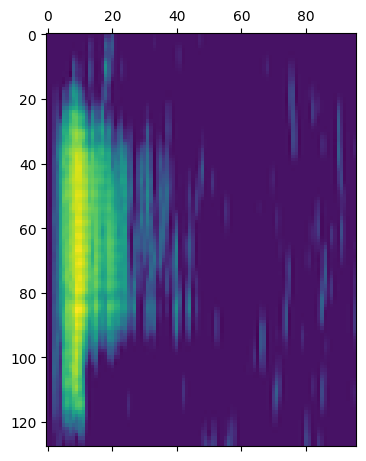

In [852]:
plt.matshow(preprocess_spec(sample_spec).T)

In [721]:
model.decode(model.encode(example_data))[0][0];

In [877]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['recon_loss'])

In [400]:
list(zip(range(N_TRAIN_BATCHES), train_dataset))[0][1].shape

2023-05-27 18:30:40.260452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [512,32,24]
	 [[{{node Placeholder/_0}}]]


TensorShape([512, 32, 24])

In [902]:
N_TRAIN_BATCHES = 32

Epoch: 0 | recon_loss: 0.007629079278558493


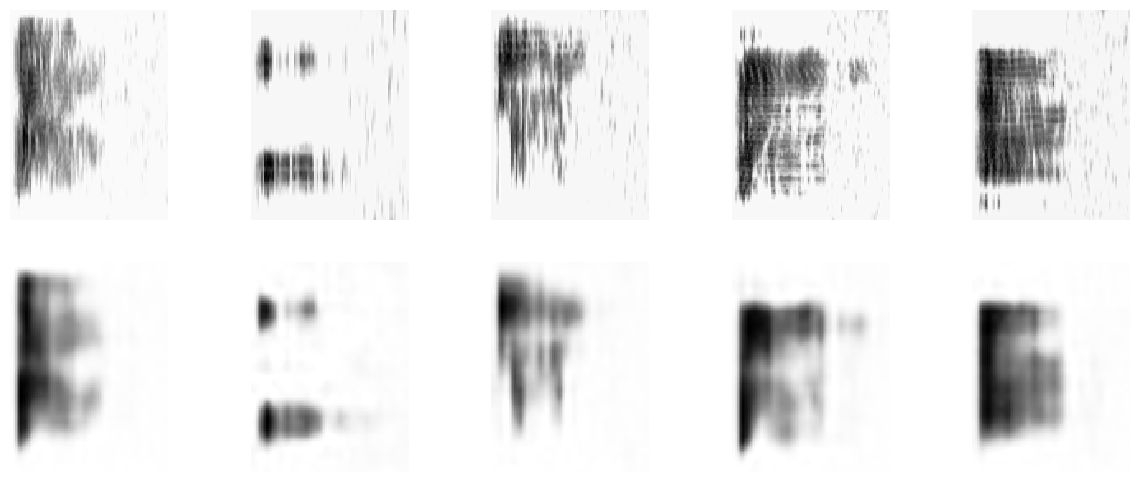

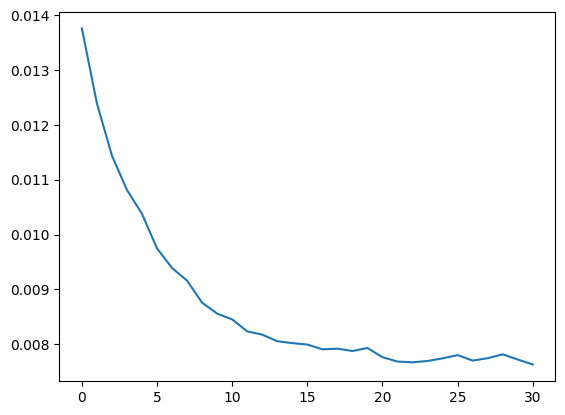

In [903]:
n_epochs = 1
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        #print(train_x[-1].numpy()[:4])
        #train_x = np.array(train_dataset[batch:BATCH_SIZE + batch].tolist())
        
        x = tf.cast(tf.reshape(train_x, [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
        
        model.train_net(x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        x = tf.cast(tf.reshape(test_x, [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
       
        loss.append(model.compute_loss(x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | recon_loss: {}".format(
            epoch, losses.recon_loss.values[-1]
        )
    )
    plot_reconstruction(model, example_data)
    plt.plot(losses.recon_loss.values)
    plt.show()

In [892]:
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')

In [899]:
98304/128/96

8.0

In [906]:
latent_vectors = []

for batch in train_dataset:
    # Pass batch through the encoder
    batch_latent = model.encode(batch)
    latent_vectors.append(batch_latent)

# Concatenate the latent vectors from all batches
latent_vectors = tf.concat(latent_vectors, axis=0)

In [907]:
latent_vectors.shape

TensorShape([5000, 32])

In [915]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = np.array(latent_vectors)
pca = PCA(n_components=3)
pca.fit(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.2260053  0.11567673 0.09090951]
[186061.22 133112.72 118005.22]


In [916]:
sum(pca.explained_variance_ratio_)

0.4325915426015854

In [911]:
latent_vectors[0]

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([ 1296.4775 ,   997.859  , -2886.3152 ,   184.98836,  -246.588  ,
        -362.44052, -1002.5964 ,   318.87332,  2621.5728 ,  -723.4381 ,
        -573.68787, -2934.7966 , -1134.0958 ,  2638.8027 , -1344.8926 ,
        1266.6849 ,  -645.52454, -1458.3673 , -1042.269  ,  5120.737  ,
       -3046.8113 ,  2149.2393 , -2439.2332 ,   903.81274,   921.705  ,
       -1620.9998 ,  1255.134  ,   337.4847 ,  -424.66385, -1409.8818 ,
         189.56227,  -923.3913 ], dtype=float32)>

In [919]:
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

pca = PCA(n_components=3)
pca.fit(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.19823834 0.11005943 0.09155049]
[178.09587 132.70084 121.02925]


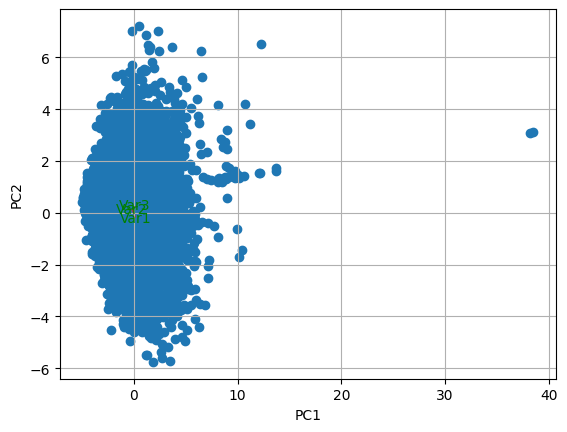

In [921]:
x_new = pca.transform(X)   

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
myplot(x_new[:,0:2], pca.components_) 
plt.show()


In [923]:
import umap
from avgn.metrics.dtw_mse import build_dtw_mse

In [931]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
#from avgn.visualization.quickplots import draw_projection_plots

from avgn.visualization.projections import scatter_spec

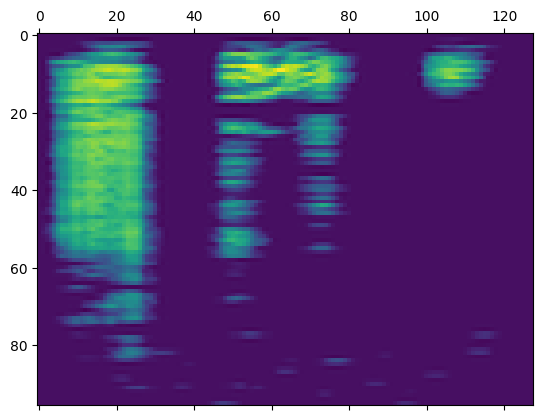

In [1060]:
plt.matshow(train_data.iloc[0].T)

In [926]:
u = umap.UMAP()
z = u.fit_transform(X)

In [1042]:
import hdbscan 

clusterer = hdbscan.HDBSCAN(
        # min_cluster_size should be the smallest size we would expect a cluster to be
        min_cluster_size=int(len(z) * 0.01), 
        min_samples = 20,
        cluster_selection_epsilon = 0.01,
        cluster_selection_method = 'leaf',
        #allow_single_cluster=True, 
        prediction_data=True # soft clustering

    ).fit(z)

In [1043]:
len(clusterer.labels_[clusterer.labels_ == -1])

3280

In [1044]:
nca = NeighborhoodComponentsAnalysis()


known_labels = clusterer.labels_[clusterer.labels_ != -1]
known_clusters = z[clusterer.labels_ != -1]

unknown_labels = clusterer.labels_[clusterer.labels_ == -1]
unknown_cluster = z[clusterer.labels_ == -1]
nca.fit(known_clusters, known_labels)

NeighborhoodComponentsAnalysis()

In [1048]:
unknown_labels

array([-1, -1, -1, ..., -1, -1, -1])

In [1055]:
reassigned_cluster = nca.transform( z[clusterer.labels_ == -1] )
len(reassigned_cluster)

3279

In [1057]:
closest_labels = nca.transform(known_clusters)
reassigned_labels = []

for i, label in enumerate(reassigned_cluster):
    closest_label_index = np.argmin(np.linalg.norm(label - closest_labels, axis=1))
    closest_label = known_labels[closest_label_index]
    reassigned_labels.append(closest_label)

clusterer.labels_[clusterer.labels_ == -1] = reassigned_labels

In [1058]:
len(clusterer.labels_[clusterer.labels_ == -1])

0

In [1028]:
unknown_labels

array([-1, -1, -1, ..., -1, -1, -1])

In [1035]:
closest_labels = nca.transform(known_clusters )
reassigned_labels = []

for i, label in enumerate(nca.transform(unknown_cluster)):
    closest_label_index = np.argmin(np.linalg.norm(label - closest_labels, axis=1))
    closest_label = known_labels[closest_label_index]
    reassigned_labels.append(closest_label)
    
clusterer.labels_[unknown_labels] = reassigned_labels

In [1036]:
np.unique(clusterer.labels_)


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [1041]:
unknown_labels

array([-1, -1, -1, ..., -1, -1, -1])

In [989]:
closest_label

array([377.83755179, -68.77863297])

In [960]:
np.unique(clusterer.labels_)

soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

In [1061]:
train_data[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00019455, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

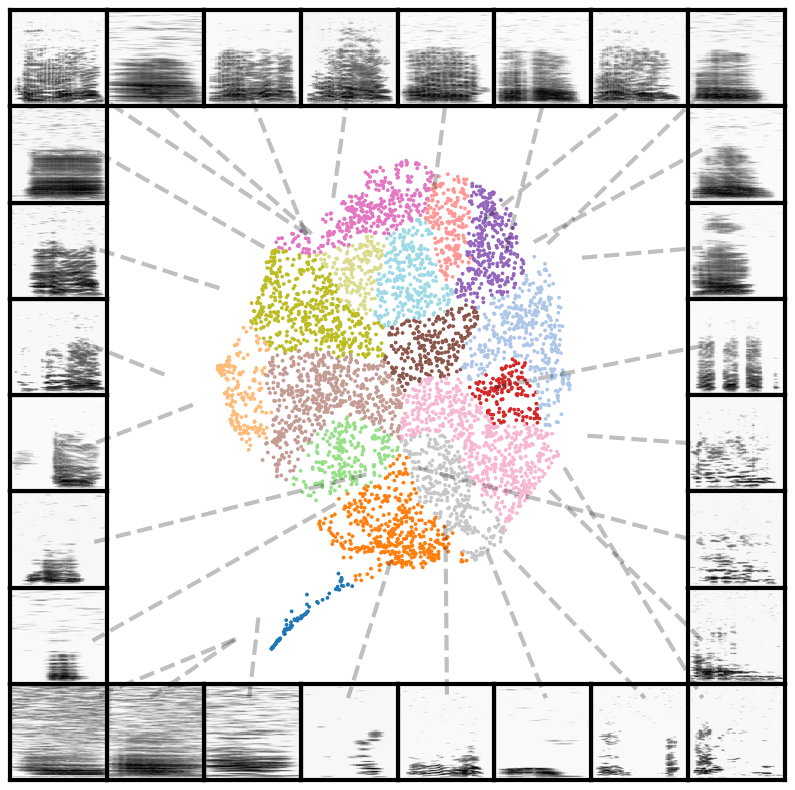

In [1062]:
scatter_spec(
    z,
    [d.T for d in train_data],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': clusterer.labels_,
        'alpha':1,
        's': 3,
        'show_legend': False,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats')
#save_fig(FIGURE_DIR / 'cassins-specs-vs-feats' / 'UMAP_feats', dpi=300, save_jpg=True)

In [946]:
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [948]:
# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=42),
)


In [956]:
nca.fit(X,X.sum(axis=1).astype(int))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('neighborhoodcomponentsanalysis',
                 NeighborhoodComponentsAnalysis(n_components=2,
                                                random_state=42))])

/tmp/ipykernel_4093123/1710875293.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=30, cmap="Set1")


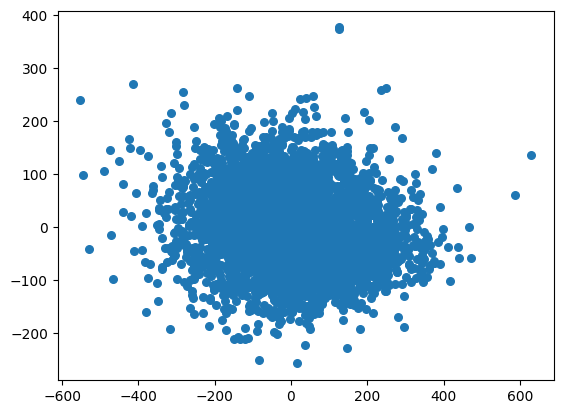

In [957]:
# Embed the data set in 2 dimensions using the fitted model
X_embedded = nca.transform(X)

# Plot the projected points and show the evaluation score
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=30, cmap="Set1")

# Using Pytorch

In [19]:
import torch
import torch.nn as nn

N_Z = 32

encoder = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=0),
    nn.GELU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
    nn.GELU(),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
    nn.GELU(),
    nn.Flatten(),
    nn.Linear(4 * 3 * 128, N_Z)
)

decoder = nn.Sequential(
    nn.Linear(N_Z, 4 * 3 * 128),
    nn.GELU(),
    nn.Unflatten(1, (128, 3, 4)),
    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),
    nn.GELU(),
    nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),
    nn.GELU(),
    nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=0),
    nn.Tanh(),
    #nn.functional.interpolate(scale_factor=(128/4, 96/3), mode='bicubic', align_corners=False)
)

In [20]:
import torch
import torch.nn as nn

class AE(nn.Module):
    def __init__(self, enc, dec):
        super(AE, self).__init__()
        self.enc = nn.Sequential(*enc)
        self.dec = nn.Sequential(*dec)

    def encode(self, x):
        return self.enc(x)

    def decode(self, z):
        return self.dec(z)

    def compute_loss(self, x):
        z = self.encode(x)
        _x = self.decode(z)
        ae_loss = torch.mean(torch.square(x - _x))
        return ae_loss

    def compute_gradients(self, x):
        self.zero_grad()
        loss = self.compute_loss(x)
        loss.backward()
        return loss

    def train_net(self, train_x, optimizer):
        optimizer.zero_grad()
        loss = self.compute_gradients(train_x)
        optimizer.step()
        return loss

In [13]:
list(encoder._modules.values())

[Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2)),
 GELU(approximate='none'),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2)),
 GELU(approximate='none'),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2)),
 GELU(approximate='none'),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=1536, out_features=32, bias=True)]

In [14]:
import torch.optim as optim

# Train the model
model = AE(enc=encoder, dec=decoder)


# Define the optimizer for the model
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Example of training loop
for epoch in range(1):
    # Perform forward pass, compute loss, and backpropagation
    loss = model.train_net(train_x, optimizer)

    # Print the loss for monitoring
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")


NameError: name 'train_x' is not defined

In [ ]:
class Autoencoder(pl.LightningModule):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 1,
                 width: int = 32,
                 height: int = 32):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
        # losses
        self.losses = {latent_dim : []}

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)
        
        
        #loss = F.mse_loss(x, x_hat, reduction="none")
        
        
        loss = F.mse_loss(x, x_hat, reduction="sum") # I choose to use mean with log-scaled spec [-80, 0]
        #loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        loss.sum().mean(dim=[0])
        #print(loss)
        
        self.losses[latent_dim].append( loss )
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)